In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from lettuce.boundary import EquilibriumBoundaryPU, EquilibriumOutletP, AntiBounceBackOutlet
from lettuce.observables import Observable
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce import ObstacleMax3D
import torch
import time
import datetime
import os
import shutil

In [2]:
### OUTPUT SETTINGS - do you want parameters, observables, plots, timeseries and/or vtk/vti-files? change the booleans below...
# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
#output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS

# name: if you want something specific in the dir-name
name = "cyl3D_Zperturb_Re300"

# data: .txt with timestamp, parameters and observable-values (mean coefficient of drag, max. coefficient of lift, Strouhal-Number) and plots
# ...will be saved in [output_path]/data_[timestamp]_[name]/
output_data = True

# vtk/vti: save vtk
# ...will be saved in [output_path]/data_[timestamp]_[name]/vtk/
output_vtk = True
vtk_fps=10  #frames per second_PU

# choose stencil (D3Q15, D3Q19, D3Q27) and collision operator ("bgk", "reg", "kbc") for 3D simulation
stencil_choice = "D3Q27"
collision_choice = "bgk"

In [4]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 300   # Reynoldsnumber
Ma = 0.05     # Machnumber
n_steps = 76210 # number of steps
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative starting point for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 10  # gp_per_D = GPD -> this defines the resolution ( D_LU = GPD+1)
domain_height_in_D = 5  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2 * domain_height_in_D  # D/X = domain length in X- / flow-direction
domain_width_in_D = domain_height_in_D  # D/Z = DpZ = diameters per domain width in Z-direction -> domain size in periodic 3rd dimension

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_height_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_height_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_height_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 0    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1, # 2: parabolic, amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46#
lateral_walls='periodic'  # type of top/bottom boundary: 'bounceback' = frictious wall, 'periodic' = periodic boundary, 'slip' = non-frictious wall
bb_type='fwbb'  # choose algorithm for bounceback-boundaries: fullway 'fwbb' or halfway 'hwbb'
cylinder = True    # obstacle: True = cylinder, False = no obstacle

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_height_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter+1)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")


mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter+1))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**3*domain_length_in_D*domain_height_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)

shape_LU: 100 x 50 x 50
T with 76210 steps: 200.0 seconds
n_steps to simulate 1 second: 381.05 steps
n_steps to simulate 200 seconds: 76210.0 steps
generates approx. 2000 .vti/.vtk-frames
No. of gridpoints: 250000


In [5]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output

    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name + "_GPD" + str(gridpoints_per_diameter) + "_" + str(domain_length_in_D) + "x" + str(domain_height_in_D) + "x" + str(domain_width_in_D) + "_" + str(stencil_choice)
    os.makedirs(output_path+dir_name)

    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)
else:
    output_vtk = False

vtk_path: /mnt/ScratchHDD1/Max_Scratch/lbm_simulations/data_230816_134133_cyl3D_Zperturb_Re300_GPD10_10x5x5_D3Q27/vtk/out
dir_name: /data_230816_134133_cyl3D_Zperturb_Re300_GPD10_10x5x5_D3Q27


In [6]:
### SIMULATOR SETUP

# stencil
if stencil_choice == "D3Q15":
    stencil=lt.D3Q15
elif stencil_choice == "D3Q19":
    stencil=lt.D3Q19
else: # stencil_choice=="D3Q27"
    stencil=lt.D3Q27

# lattice
# lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64, native=False)  # for "new lettuce"
lattice = lt.Lattice(stencil, "cuda:0", dtype=torch.float64)  #for "old lettuce"
    # stencil, device, dtype

flow = ObstacleMax3D(reynolds_number=re, mach_number=Ma,
                   lattice=lattice,
                   char_length_pu=setup_diameter,
                   char_length_lu=gridpoints_per_diameter+1,
                   char_velocity_pu=flow_velocity,
                   x_lu=domain_length_in_D*gridpoints_per_diameter,
                   y_lu=domain_height_in_D*gridpoints_per_diameter,
                   z_lu=domain_width_in_D*gridpoints_per_diameter,
                   lateral_walls=lateral_walls,
                   bb_type=bb_type,
                   perturb_init=perturb_init,
                   u_init=u_init
                  )

# define a Cylinder-Obstacle
radius_LU = 0.5 * gridpoints_per_diameter
y_pos_LU = 0.5 * gridpoints_per_diameter * domain_height_in_D + 0.5
x_pos_LU = y_pos_LU

index_list = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel index lists (1-n (non zero-based!))
xLU, yLU, zLU = np.meshgrid(*index_list, indexing='ij')  # meshgrid of x-, y- (and z-)indizes/indexs?/indexes?! - this is simulation, not grammar...

condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
flow.obstacle_mask[np.where(condition)] = 1

### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu

# collision
if collision_choice == "reg":
    collision=lt.RegularizedCollision(lattice, tau)
elif collision_choice == "kbc":
    collision=lt.KBCCollision3D(lattice,tau)
else: # collision_choice = "bgk":
    collision=lt.BGKCollision

# simulation
sim = lt.Simulation(flow, lattice,
                    lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, CollisionOperator-Object(Parameter), Streaming-Object

### Reporter

# VTK Reporter -> Visualization
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))  # ! area A=2*r is in PU and 1-dimensional in 2D
Dragreport = lt.ObservableReporter(DragObservable, out=None)
sim.reporters.append(Dragreport)

# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter*flow.units.convert_length_to_pu(gridpoints_per_diameter*domain_width_in_D))
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

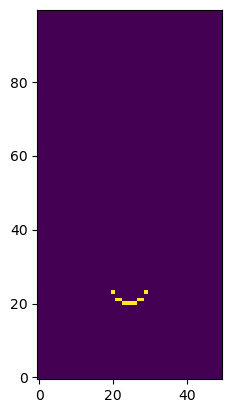

In [7]:
from matplotlib import pyplot as plt
#plt.imshow(u_out[0,...].T, origin="lower")
plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[1,:,:,0]), origin="lower")

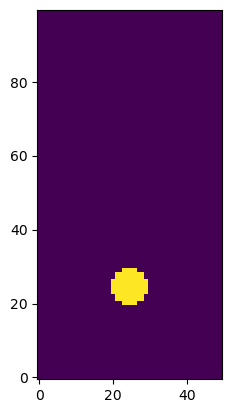

In [8]:
plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask)[:,:,0], origin="lower")

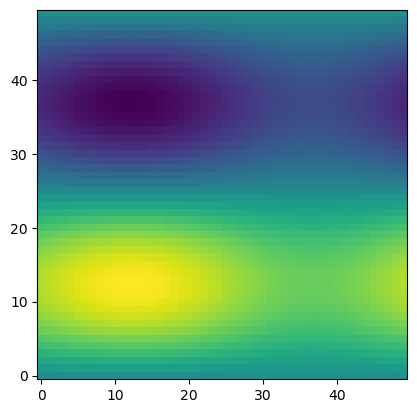

In [9]:
plt.imshow(lattice.convert_to_numpy(lattice.u(sim.f))[0,1,:,:], origin="lower")

In [10]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #simulation

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")
print("Re:",re)

MLUPS: 10.617657984453146
PU-Time:  199.9993818860972  seconds
number of steps: 76210
runtime:  1794.4165623188019 seconds ( 29.91 minutes )
Re: 300


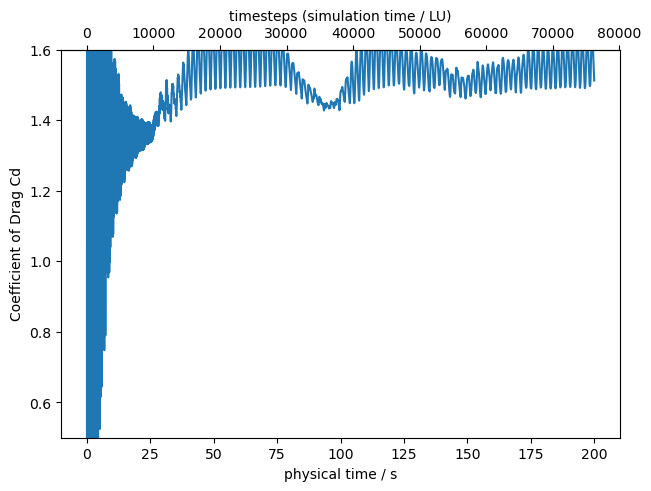

In [11]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

Cd, simple mean:      1.563345265815609
Cd, peak_finder mean: 1.5631611038562478
start time of 'mean'-ing: 179.9968193780821


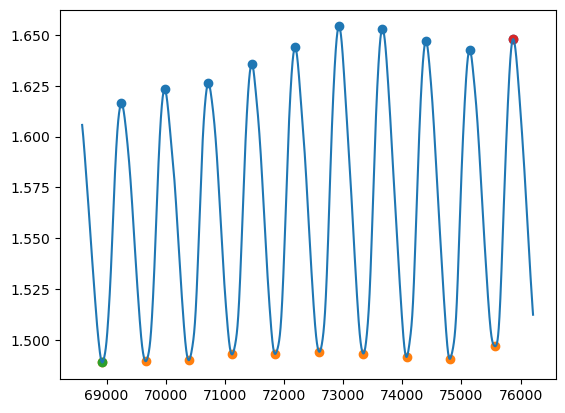

In [12]:
### calculate mean drag_coefficient in periodic region:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks only works correctly, if simulation is converged in the periodic region...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("Cd, simple mean:     ",drag_mean_simple)
    print("Cd, peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

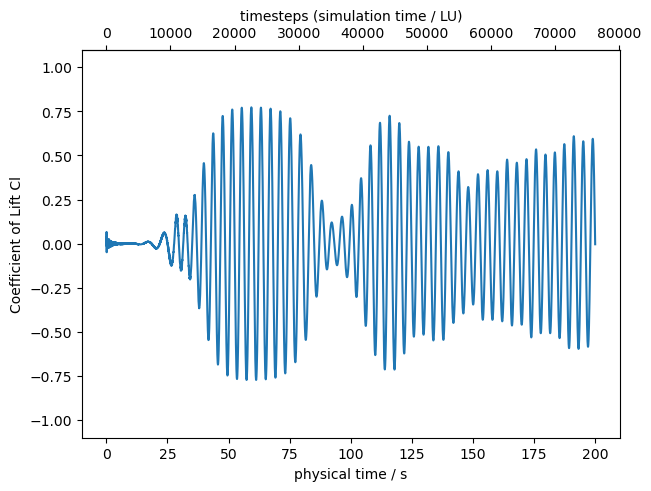

Cl_peaks: 
min -0.7137195251087682 
max 0.7251586461743291


In [13]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

Frequency Peak: 0.24999749226827683 +- 0.004999949845365537 Hz


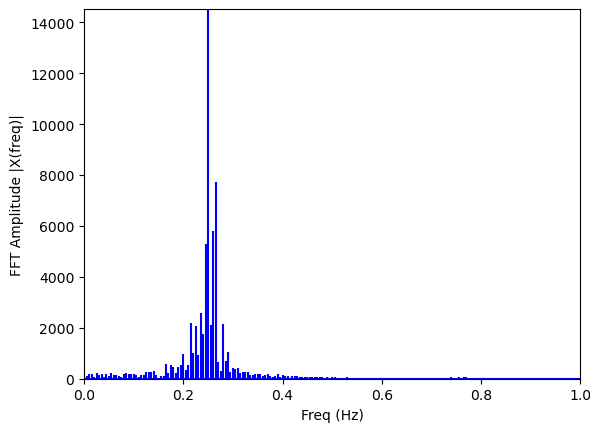

In [14]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")

    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with the highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

In [15]:
# save notebook to simulation_output
if output_data:
    shutil.copy(str(os.getcwd())+"/cylinder3D_development.ipynb",output_path+dir_name+"/script.ipynb")
else:
    print("output_data-toggle is FALSE")

In [16]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\ndomain_height_in_D (D/Y) = "+str(domain_height_in_D))
    output_file.write("\ndomain_width_in_D (D/Z) = "+str(domain_width_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\nbb_type = "+str(bb_type))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\noutput_vtk = "+str(output_vtk))
    output_file.write("\n")
    output_file.write("\nshape_LU: "+ str(flow.shape[0]) + " x " + str(flow.shape[1]) + " x " + str(flow.shape[2]))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    output_file.write("\n###################\n\ncylinder:")
    output_file.write("\nradius_LU = "+str(radius_LU))
    output_file.write("\nx_pos_LU = "+str(x_pos_LU))
    output_file.write("\ny_pos_LU = "+str(y_pos_LU))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.close()


In [17]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   67875 KB |  290634 KB |  110304 GB |  110304 GB |
|       from large pool |   67136 KB |  289894 KB |  109801 GB |  109800 GB |
|       from small pool |     739 KB |    2889 KB |     503 GB |     503 GB |
|---------------------------------------------------------------------------|
| Active memory         |   67875 KB |  290634 KB |  110304 GB |  110304 GB |
|       from large pool |   67136 KB |  289894 KB |  109801 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [16]:
lattice.convert_to_numpy(lattice.u(sim.f)).shape

(3, 760, 380, 3)

In [17]:
lattice.convert_to_numpy(lattice.u(sim.f))[:,:,:,0]

array([[[ 2.88675135e-02,  2.88675135e-02,  2.88675135e-02, ...,
          2.88675135e-02,  2.88675135e-02,  2.88675135e-02],
        [ 1.81711547e-02,  1.81710779e-02,  1.81710136e-02, ...,
          1.81709935e-02,  1.81710655e-02,  1.81711505e-02],
        [ 1.81695684e-02,  1.81694985e-02,  1.81694517e-02, ...,
          1.81694302e-02,  1.81694850e-02,  1.81695637e-02],
        ...,
        [-4.57758831e-14, -4.60933375e-14, -4.55885329e-14, ...,
         -4.58903748e-14, -4.61766042e-14, -4.60100708e-14],
        [-4.58539456e-14, -4.58851707e-14, -4.53127119e-14, ...,
         -4.62026251e-14, -4.63379335e-14, -4.62546668e-14],
        [-4.58591498e-14, -4.58955790e-14, -4.52918952e-14, ...,
         -4.62078292e-14, -4.63431377e-14, -4.62754834e-14]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.56717387e-07,  8.78632684e-07,  1.38090308e-06, ...,
         -1.19268133e-06, -6.92334716e

In [18]:
flow.boundaries